In [51]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scikeras.wrappers import KerasClassifier, KerasRegressor
import gradio as gd

In [52]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [53]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2023_08_15-12_51_07'

In [54]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [55]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [56]:
X_valid.shape

(5000, 28, 28)

In [57]:
y_valid.shape

(5000,)

In [58]:
X_train.shape

(55000, 28, 28)

In [59]:
y_train.shape

(55000,)

In [60]:
X_test.shape

(10000, 28, 28)

In [61]:
y_test.shape

(10000,)

C:\Users\davep\AppData\Local\Temp/ipykernel_22104/1027188644.py:11: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


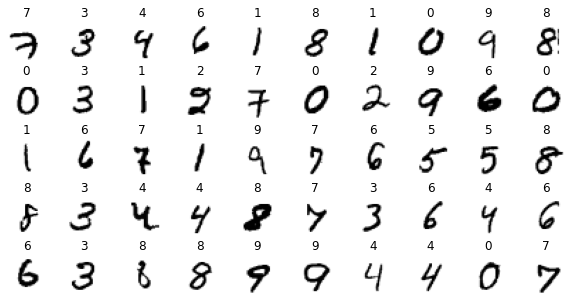

In [62]:
#Just some code showing 
fig, axes = plt.subplots(5, 10, figsize=(10, 5))
axes = axes.flatten()
for i in range(50):
    ax = axes[i]
    ax.imshow(X_train[i], cmap='binary')
    ax.axis('off')  # Turn off axis labels
    ax.set_title(str(y_train[i]))
    
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [63]:
X_train_full[0].shape

(28, 28)

In [64]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


In [65]:
#You can see that the model weights are randomly initialized to introduce nonlinearity into the data 
model.layers[1].get_weights()

[array([[-0.00958908,  0.00369985, -0.00048406, ..., -0.07357587,
         -0.02742664, -0.04121105],
        [ 0.06529447, -0.07138363,  0.05846708, ..., -0.0041897 ,
          0.06529114, -0.03365361],
        [ 0.05264154, -0.03162553,  0.01164634, ..., -0.04076129,
          0.01914155, -0.03140609],
        ...,
        [ 0.0286293 ,  0.03434967, -0.00212682, ..., -0.0253939 ,
          0.06216036,  0.01375941],
        [ 0.00351328,  0.05891068, -0.01023991, ...,  0.05314083,
         -0.06726155,  0.07313393],
        [-0.00130923,  0.045985  ,  0.04936647, ...,  0.02184285,
         -0.01658475,  0.06170258]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [66]:
X_train.shape

(55000, 28, 28)

In [67]:
y_train.shape

(55000,)

In [68]:
y_train = y_train.reshape(-1, 1)  # Reshape y_train to (num_samples, 1)
y_valid = y_valid.reshape(-1, 1)

In [69]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [70]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [71]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [72]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.6033 - val_loss: nan - val_accuracy: 0.0958


Text(0, 0.5, 'Loss')

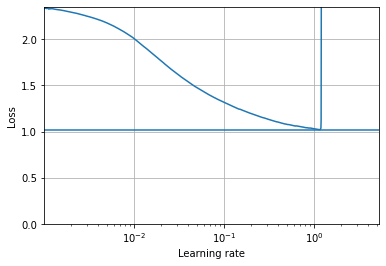

In [73]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [74]:
#optimal learning rate is 0.3. Optimal strat to find best learning rate is by defining a custom call
#back, that at the end of every batch, you append the loss and learning rate using the keras backend, 
#and then increase the learning rate by the passed in factor 
keras.backend.clear_session()

In [75]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


In [76]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=0.3),
              metrics=["accuracy"])

In [77]:
es = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
cb = keras.callbacks.ModelCheckpoint("mnist_model_V1")

In [78]:
model=keras.models.load_model("mnist_model_V1")

In [79]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 22.6567 - accuracy: 0.9773


[22.656667709350586, 0.9772999882698059]

In [80]:
tcb = keras.callbacks.TensorBoard(run_logdir)

In [81]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[es, cb, tcb])

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0861 - val_accuracy: 0.9822
Epoch 2/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0834 - val_accuracy: 0.9834
Epoch 3/30
1719/1719 [==============================] - 4s 3ms/step - loss: 5.7669e-04 - accuracy: 0.9999 - val_loss: 0.0790 - val_accuracy: 0.9862
Epoch 4/30
1719/1719 [==============================] - 4s 3ms/step - loss: 4.2352e-04 - accuracy: 0.9999 - val_loss: 0.0809 - val_accuracy: 0.9856
Epoch 5/30
1719/1719 [==============================] - 4s 3ms/step - loss: 1.4140e-04 - accuracy: 1.0000 - val_loss: 0.0814 - val_accuracy: 0.9860
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 9.4447e-05 - accuracy: 1.0000 - val_loss: 0.0821 - val_accuracy: 0.9860
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 7.9817e-05 - accuracy: 1.0000 - val_loss: 0.

In [84]:
def predict_sketch(sketch):
    if np.sum(sketch) == 0:
        # Return placeholder labels when the sketchpad is cleared
        return {f"Class {i}": "N/A" for i in range(5)}
    
    try:
        # Preprocess the sketch (e.g., resize, normalize)
        sketch_array = np.array(sketch).reshape(-1, 28, 28, 1)
        
        # Get class probabilities from the model
        class_probs = model.predict(sketch_array)[0]
        
        # Get the top 5 class probabilities and their corresponding labels
        top_indices = class_probs.argsort()[-5:][::-1]
        top_probs = [class_probs[i] for i in top_indices]
        
        return {
            f"Class {i}": f"{prob:.2f}" for i, prob in zip(top_indices, top_probs)
        }
    except:
        # Handle unexpected errors gracefully
        return {f"Class {i}": "Error" for i in range(5)}

In [87]:
gd.Interface(fn=predict_sketch,
             inputs="sketchpad",
             outputs="label",
             live=True).launch(share=True)

Running on local URL:  http://127.0.0.1:7868
Running on public URL: https://a6ed2af8f7323ac961.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
